In [1]:
# Add project root to Python path
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
print(f"Project root added to path: {project_root}")

Project root added to path: /Users/kevin/Documents/repos/flit-ml


# BNPL Data Exploration

**Objective**: Comprehensive exploratory data analysis of BNPL staging data

**Data Source**: `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
- **Records**: ~1.9M transactions
- **Fields**: 42 columns
- **Time Range**: Sep 2024-Aug2025

**Research Questions**:
1. What is the distribution of transaction amounts?
2. How do customer demographics correlate with risk?
3. What temporal patterns exist in BNPL usage?
4. What are the key predictive features for default risk?

In [2]:
# Environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# BigQuery integration
from google.cloud import bigquery
from flit_ml.config import config

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print("Environment setup complete!")

Environment setup complete!


## 1. Data Connection and Schema Analysis

In [3]:
# Connect to BigQuery
client = config.get_client()

# Test connection with basic query
test_query = """
SELECT COUNT(*) as total_records
FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
"""

result = client.query(test_query).result()
for row in result:
    print(f"✅ Connected to BigQuery: {row.total_records:,} total records")

✅ Connected to BigQuery: 1,943,795 total records


In [4]:
# Get table schema information
schema_query = """
SELECT
    column_name,
    data_type,
    is_nullable,
    --description
FROM `flit-data-platform.flit_staging.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'stg_bnpl_raw_transactions'
ORDER BY ordinal_position
"""

schema_df = client.query(schema_query).to_dataframe()
print(f"📊 Schema: {len(schema_df)} columns")
schema_df.head(20)

E0000 00:00:1758382414.595913 22446885 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


📊 Schema: 50 columns


,column_name,data_type,is_nullable
0,unique_transaction_id,STRING,YES
1,_generator,STRING,YES
2,_record_id,STRING,YES
3,_timestamp,STRING,YES
4,amount,FLOAT64,YES
5,cart_abandonment_count,FLOAT64,YES
6,checkout_speed,FLOAT64,YES
7,currency,STRING,YES
8,customer_address_stability,FLOAT64,YES
9,customer_age_bracket,STRING,YES


## 2. Sample Data Inspection

In [5]:
# Get sample records for initial inspection
sample_query = """
SELECT *
FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
ORDER BY RAND()
LIMIT 1000
"""

# Load sample data
print("📥 Loading sample data...")
sample_df = client.query(sample_query).to_dataframe()

print(f"Sample data shape: {sample_df.shape}")
print(f"Memory usage: {sample_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

sample_df.head()

📥 Loading sample data...


E0000 00:00:1758382441.600708 22446885 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Sample data shape: (1000, 50)
Memory usage: 3.4 MB


,unique_transaction_id,_generator,_record_id,_timestamp,amount,cart_abandonment_count,checkout_speed,currency,customer_address_stability,customer_age_bracket,customer_credit_score_range,customer_id,customer_income_bracket,customer_state,customer_tenure_days,customer_verification_level,days_to_first_missed_payment,device_id,device_is_trusted,device_os,device_type,economic_stress_factor,first_payment_amount,installment_count,payment_credit_limit,payment_frequency,payment_method_id,payment_provider,payment_type,price_comparison_time,product_bnpl_eligible,product_brand,product_category,product_id,product_price,product_risk_category,product_subcategory,purchase_context,risk_level,risk_scenario,risk_score,status,time_on_site_seconds,transaction_id,will_default,transaction_timestamp,_ingestion_timestamp,json_body,data_source,_loaded_at
0,9a88effe34dde4e42e3082927cd42901,BNPLGenerator,49062,2025-08-16T13:51:47,134.29,2.0,NaN,USD,NaN,45-54,fair,cust_001583,<25k,UT,171.0,unverified,None,cust_001583_device_2,True,Android,mobile,0.0,33.57,6.0,500.0,bi_weekly,cust_001583_pm_2,sezzle,bnpl_account,263.0,True,Zara,clothing,prod_001074,134.29,low,dresses,normal,medium,low_risk_purchase,0.54,completed,820,txn_00049062,False,2025-08-16 13:51:47+00:00,2025-09-20 14:58:40.527333+00:00,"{""transaction_id"": ""txn_00049062"", ""customer_i...",bnpl_api,2025-09-20 15:33:37.631347+00:00
1,7ec7b66e9f748af6ceb39250b033f0fe,BNPLGenerator,42426,2025-05-16T11:52:32,80.33,3.0,NaN,USD,NaN,45-54,fair,cust_001876,<25k,NC,606.0,verified,None,cust_001876_device_1,True,Android,mobile,0.0,20.08,4.0,500.0,bi_weekly,cust_001876_pm_2,klarna,bnpl_account,274.0,True,Sephora,home,prod_001027,80.33,medium,furniture,normal,medium,low_risk_purchase,0.42,completed,592,txn_00042426,False,2025-05-16 11:52:32+00:00,2025-09-20 14:39:08.253659+00:00,"{""transaction_id"": ""txn_00042426"", ""customer_i...",bnpl_api,2025-09-20 15:33:37.631347+00:00
2,f9d86644a27dbc42c737e54727578bf7,BNPLGenerator,33557,2024-10-27T06:18:10,48.51,1.0,NaN,USD,NaN,55+,excellent,cust_003672,25k-50k,MN,301.0,partial,None,cust_003672_device_2,True,iOS,mobile,0.0,12.13,4.0,1500.0,bi_weekly,cust_003672_pm_2,afterpay,bnpl_account,98.0,False,Zara,electronics,prod_002816,48.51,medium,smartphones,normal,low,low_risk_purchase,0.29,completed,297,txn_00033557,False,2024-10-27 06:18:10+00:00,2025-09-20 14:00:57.967252+00:00,"{""transaction_id"": ""txn_00033557"", ""customer_i...",bnpl_api,2025-09-20 15:33:37.631347+00:00
3,79d717633af504420339827a2e7b37d3,BNPLGenerator,32571,2025-08-13T20:14:06,74.49,0.0,NaN,USD,NaN,35-44,fair,cust_003533,75k-100k,WY,692.0,verified,None,cust_003533_device_2,True,Android,mobile,0.0,18.62,4.0,5000.0,bi_weekly,cust_003533_pm_1,klarna,bnpl_account,52.0,True,Adidas,clothing,prod_003847,74.49,high,shoes,impulse,medium,impulse_purchase,0.36,completed,186,txn_00032571,False,2025-08-13 20:14:06+00:00,2025-09-20 14:58:40.527333+00:00,"{""transaction_id"": ""txn_00032571"", ""customer_i...",bnpl_api,2025-09-20 15:33:37.631347+00:00
4,7c58174e2c1fa7dcacd0bf27deade2a0,BNPLGenerator,7634,2024-12-22T00:07:31,93.12,2.0,NaN,USD,NaN,55+,poor,cust_001276,50k-75k,NE,676.0,verified,None,cust_001276_device_2,True,Linux,desktop,0.0,23.28,4.0,1500.0,bi_weekly,cust_001276_pm_3,sezzle,bnpl_account,71.0,True,Zara,clothing,prod_000602,93.12,low,shoes,normal,medium,low_risk_purchase,0.39,completed,640,txn_00007634,False,2024-12-22 00:07:31+00:00,2025-09-20 14:15:17.776036+00:00,"{""transaction_id"": ""txn_00007634"", ""customer_i...",bnpl_api,2025-09-20 15:33:37.631347+00:00


In [6]:
# Data types and basic info
print("📋 Data Types and Info:")
sample_df.info()

📋 Data Types and Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   unique_transaction_id         1000 non-null   object             
 1   _generator                    1000 non-null   object             
 2   _record_id                    1000 non-null   object             
 3   _timestamp                    1000 non-null   object             
 4   amount                        1000 non-null   float64            
 5   cart_abandonment_count        1000 non-null   float64            
 6   checkout_speed                0 non-null      float64            
 7   currency                      1000 non-null   object             
 8   customer_address_stability    0 non-null      float64            
 9   customer_age_bracket          1000 non-null   object             
 10  customer_credi

In [7]:
# Statistical summary for numeric columns
print("📈 Statistical Summary:")
sample_df.describe()

📈 Statistical Summary:


,amount,cart_abandonment_count,checkout_speed,customer_address_stability,customer_tenure_days,economic_stress_factor,first_payment_amount,installment_count,payment_credit_limit,price_comparison_time,product_price,risk_score
count,1000.000000,1000.00000,0.0,0.0,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,135.578090,1.46900,NaN,NaN,377.372000,0.0,33.894390,4.506000,2114.000000,139.040000,135.578090,0.348990
std,96.939844,1.13328,NaN,NaN,211.317947,0.0,24.234933,0.869897,1610.154215,90.379793,96.939844,0.105888
min,15.280000,0.00000,NaN,NaN,1.000000,0.0,3.820000,4.000000,500.000000,0.000000,15.280000,0.110000
25%,56.197500,0.00000,NaN,NaN,196.750000,0.0,14.050000,4.000000,1000.000000,58.000000,56.197500,0.270000
50%,106.100000,1.00000,NaN,NaN,381.000000,0.0,26.525000,4.000000,1500.000000,134.500000,106.100000,0.350000
75%,193.325000,2.00000,NaN,NaN,552.000000,0.0,48.327500,6.000000,2500.000000,217.250000,193.325000,0.420000
max,398.350000,3.00000,NaN,NaN,731.000000,0.0,99.590000,6.000000,5000.000000,300.000000,398.350000,0.650000


## 3. Data Quality Assessment

In [8]:
# Missing values analysis
missing_stats = {
    'column': sample_df.columns,
    'missing_count': sample_df.isnull().sum(),
    'missing_percent': (sample_df.isnull().sum() / len(sample_df) * 100).round(2),
    'dtype': sample_df.dtypes
}

missing_df = pd.DataFrame(missing_stats)
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_percent', ascending=False)

print("❓ Missing Values Analysis:")
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✅ No missing values found in sample data")

❓ Missing Values Analysis:
                                                    column  missing_count  \
checkout_speed                              checkout_speed           1000   
customer_address_stability      customer_address_stability           1000   
days_to_first_missed_payment  days_to_first_missed_payment            935   

                              missing_percent    dtype  
checkout_speed                          100.0  float64  
customer_address_stability              100.0  float64  
days_to_first_missed_payment             93.5   object  


In [9]:
# Unique values count for potential categorical variables
print("🏷️  Categorical Variables Analysis:")

categorical_analysis = []
for col in sample_df.columns:
    unique_count = sample_df[col].nunique()
    unique_ratio = unique_count / len(sample_df)
    
    # Identify potential categorical variables
    if unique_ratio < 0.1 and unique_count < 50:
        categorical_analysis.append({
            'column': col,
            'unique_count': unique_count,
            'unique_ratio': round(unique_ratio, 3),
            'sample_values': list(sample_df[col].value_counts().head(5).index)
        })

if categorical_analysis:
    cat_df = pd.DataFrame(categorical_analysis)
    for _, row in cat_df.iterrows():
        print(f"{row['column']}: {row['unique_count']} unique values ({row['unique_ratio']*100:.1f}%)")
        print(f"  Sample values: {row['sample_values']}")
        print()
else:
    print("No obvious categorical variables detected in sample")

🏷️  Categorical Variables Analysis:
_generator: 1 unique values (0.1%)
  Sample values: ['BNPLGenerator']

cart_abandonment_count: 4 unique values (0.4%)
  Sample values: [0.0, 2.0, 3.0, 1.0]

checkout_speed: 0 unique values (0.0%)
  Sample values: []

currency: 1 unique values (0.1%)
  Sample values: ['USD']

customer_address_stability: 0 unique values (0.0%)
  Sample values: []

customer_age_bracket: 5 unique values (0.5%)
  Sample values: ['55+', '45-54', '35-44', '25-34', '18-24']

customer_credit_score_range: 4 unique values (0.4%)
  Sample values: ['good', 'fair', 'poor', 'excellent']

customer_income_bracket: 5 unique values (0.5%)
  Sample values: ['25k-50k', '50k-75k', '75k-100k', '100k+', '<25k']

customer_verification_level: 3 unique values (0.3%)
  Sample values: ['verified', 'partial', 'unverified']

days_to_first_missed_payment: 6 unique values (0.6%)
  Sample values: ['42', '28', '56', '14', '70']

device_is_trusted: 2 unique values (0.2%)
  Sample values: [True, False]


## 4. Key Business Metrics Overview

Understanding the business context of BNPL transactions

In [10]:
# Basic business metrics from full dataset - FIXED SQL
business_metrics_query = """
WITH base_metrics AS (
  SELECT
    COUNT(*) as total_transactions,
    COUNT(DISTINCT customer_id) as unique_customers,
    AVG(amount) as avg_transaction_amount,
    STDDEV(amount) as std_transaction_amount,
    MIN(amount) as min_transaction_amount,
    MAX(amount) as max_transaction_amount,
    MIN(transaction_timestamp) as earliest_transaction,
    MAX(transaction_timestamp) as latest_transaction
  FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
),
percentiles AS (
  SELECT
    APPROX_QUANTILES(amount, 4)[OFFSET(1)] as p25_transaction_amount,
    APPROX_QUANTILES(amount, 4)[OFFSET(2)] as median_transaction_amount,
    APPROX_QUANTILES(amount, 4)[OFFSET(3)] as p75_transaction_amount
  FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
)
SELECT * FROM base_metrics, percentiles
"""

print("📊 Business Metrics Overview:")
business_metrics = client.query(business_metrics_query).to_dataframe()
business_metrics.T

📊 Business Metrics Overview:


E0000 00:00:1758382447.016203 22446885 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


,0
total_transactions,1943795
unique_customers,22663
avg_transaction_amount,143.859218
std_transaction_amount,98.976745
min_transaction_amount,15.01
max_transaction_amount,400.0
earliest_transaction,2024-09-01 00:02:40+00:00
latest_transaction,2025-08-31 23:58:45+00:00
p25_transaction_amount,63.25
median_transaction_amount,116.54


#### 5. Next Notebook Handover

In [11]:
# Save key insights for next notebook
insights = {
    'total_records': int(business_metrics['total_transactions'].iloc[0]),
    'unique_customers': int(business_metrics['unique_customers'].iloc[0]),
    'avg_transaction': float(business_metrics['avg_transaction_amount'].iloc[0]),
    'date_range': {
        'start': str(business_metrics['earliest_transaction'].iloc[0]),
        'end': str(business_metrics['latest_transaction'].iloc[0])
    },
    'schema_columns': len(schema_df),
    'sample_size': len(sample_df)
}

print("💾 Key Insights Summary:")
for key, value in insights.items():
    print(f"{key}: {value}")

# TODO: Save insights to file for next notebooks
# import json
# with open('../reports/data_exploration_insights.json', 'w') as f:
#     json.dump(insights, f, indent=2)

💾 Key Insights Summary:
total_records: 1943795
unique_customers: 22663
avg_transaction: 143.8592177004266
date_range: {'start': '2024-09-01 00:02:40+00:00', 'end': '2025-08-31 23:58:45+00:00'}
schema_columns: 50
sample_size: 1000


## 6. Visualization

Based on the initial exploration, we can now fetch more data and visualize the data

In [20]:
# Load larger sample for comprehensive analysis
print("📥 Loading larger sample for visualization analysis...")

viz_query = """
SELECT 
    customer_id,
    amount,
    will_default,
    risk_level,
    risk_score,
    customer_credit_score_range,
    customer_age_bracket,
    customer_income_bracket,
    customer_verification_level,
    customer_tenure_days,
    product_category,
    product_risk_category,
    product_price,
    payment_type,
    device_type,
    economic_stress_factor,
    transaction_timestamp
FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
ORDER BY RAND()
LIMIT 150000
"""

# Load data for visualization
viz_df = client.query(viz_query).to_dataframe()

print(f"✅ Loaded {len(viz_df):,} records for visualization")
print(f"Memory usage: {viz_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Basic info
print(f"\n📊 Sample characteristics:")
print(f"Default rate: {viz_df['will_default'].mean():.1%}")
print(f"Unique customers: {viz_df['customer_id'].nunique():,}")
print(f"Date range: {viz_df['transaction_timestamp'].min()} to {viz_df['transaction_timestamp'].max()}")

📥 Loading larger sample for visualization analysis...


E0000 00:00:1758390363.480320 22446885 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅ Loaded 150,000 records for visualization
Memory usage: 98.7 MB

📊 Sample characteristics:
Default rate: 4.9%
Unique customers: 18,319
Date range: 2024-09-01 00:12:09+00:00 to 2025-08-31 23:56:31+00:00


### 6.1 General Business xtics

/Users/kevin/Library/Caches/pypoetry/virtualenvs/flit-ml-Ja6BlcxJ-py3.11/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


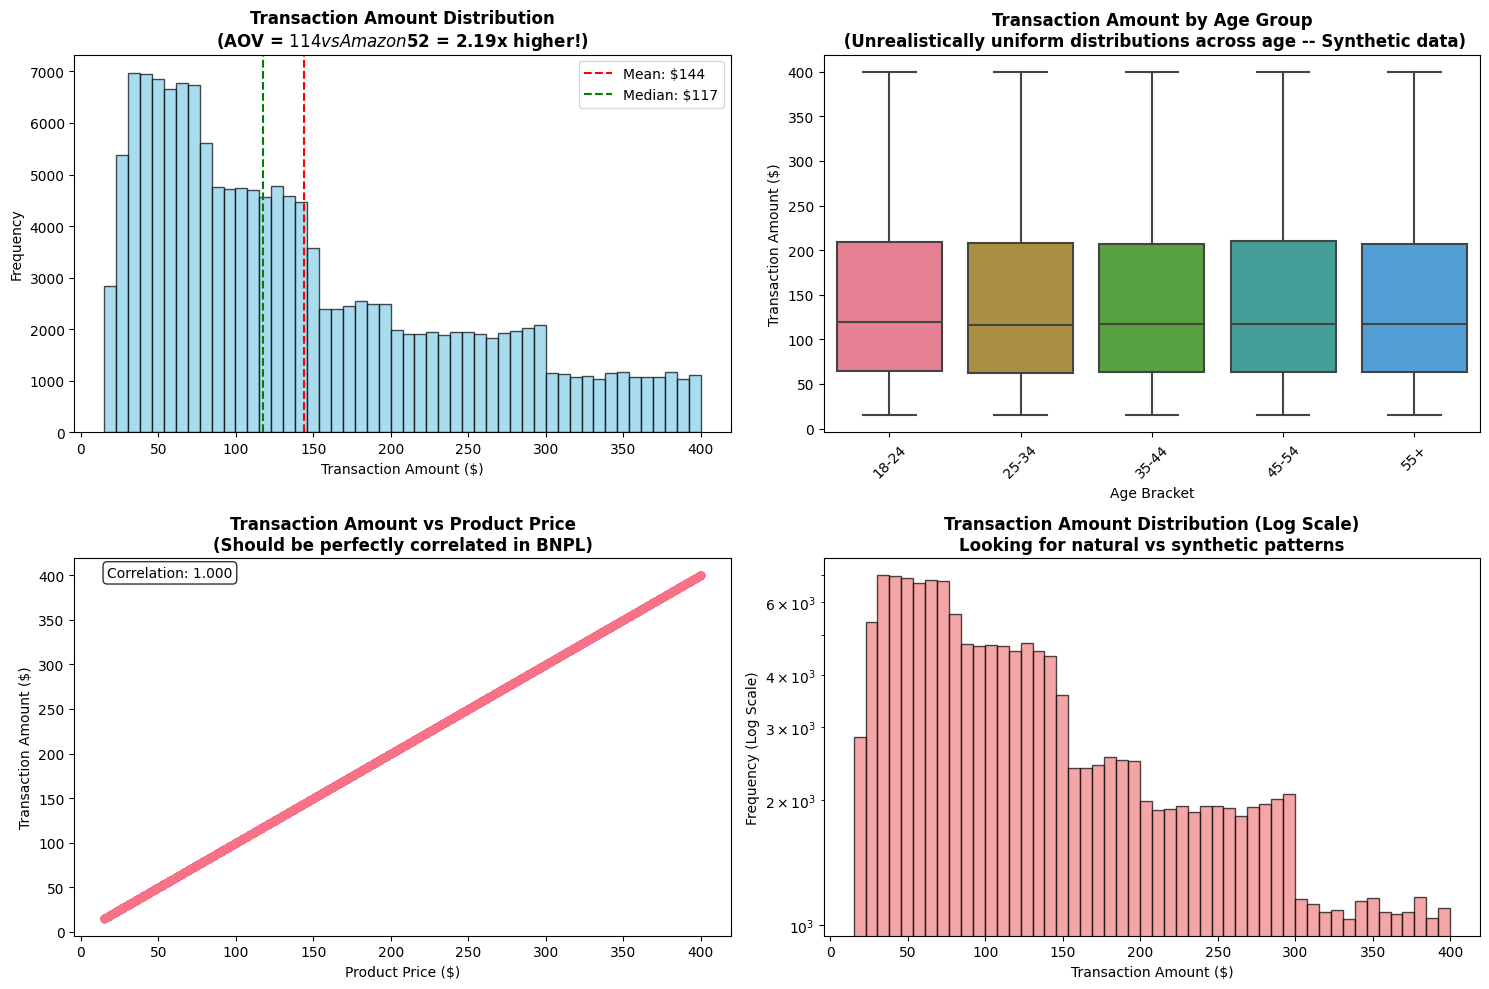

💰 TRANSACTION AMOUNT INSIGHTS:
Mean AOV: $143.88
Median AOV: $117.17
Standard Deviation: $99.06
Min: $15.01, Max: $400.00

🔍 Business Context:
Amazon AOV ≈ $52, Flit AOV = $144 (2.8x higher)
This suggests either premium positioning or unrealistic synthetic data


In [22]:
# Transaction Amount Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of transaction amounts
axes[0,0].hist(viz_df['amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Transaction Amount Distribution\n(AOV = $114  vs  Amazon $52 = 2.19x higher!)', fontweight='bold')
axes[0,0].set_xlabel('Transaction Amount ($)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(viz_df['amount'].mean(), color='red', linestyle='--', label=f'Mean: ${viz_df["amount"].mean():.0f}')
axes[0,0].axvline(viz_df['amount'].median(), color='green', linestyle='--', label=f'Median: ${viz_df["amount"].median():.0f}')
axes[0,0].legend()

# 2. Box plot by customer age - testing AOV vs Age hypothesis
age_order = ['18-24', '25-34', '35-44', '45-54', '55+']
viz_df['age_ordered'] = pd.Categorical(viz_df['customer_age_bracket'], categories=age_order, ordered=True)
sns.boxplot(data=viz_df, x='age_ordered', y='amount', ax=axes[0,1])
axes[0,1].set_title('Transaction Amount by Age Group\n (Unrealistically uniform distributions across age -- Synthetic data)', fontweight='bold')
axes[0,1].set_xlabel('Age Bracket')
axes[0,1].set_ylabel('Transaction Amount ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Amount vs Product Price scatter (should be correlated)
axes[1,0].scatter(viz_df['product_price'], viz_df['amount'], alpha=0.6, s=20)
axes[1,0].set_title('Transaction Amount vs Product Price\n(Should be perfectly correlated in BNPL)', fontweight='bold')
axes[1,0].set_xlabel('Product Price ($)')
axes[1,0].set_ylabel('Transaction Amount ($)')
# Add correlation coefficient
corr_coef = viz_df['amount'].corr(viz_df['product_price'])
axes[1,0].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', transform=axes[1,0].transAxes, 
               bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

# 4. Log scale histogram to see distribution shape better
axes[1,1].hist(viz_df['amount'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,1].set_yscale('log')
axes[1,1].set_title('Transaction Amount Distribution (Log Scale)\nLooking for natural vs synthetic patterns', fontweight='bold')
axes[1,1].set_xlabel('Transaction Amount ($)')
axes[1,1].set_ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

# Summary statistics with business context
print("💰 TRANSACTION AMOUNT INSIGHTS:")
print(f"Mean AOV: ${viz_df['amount'].mean():.2f}")
print(f"Median AOV: ${viz_df['amount'].median():.2f}")
print(f"Standard Deviation: ${viz_df['amount'].std():.2f}")
print(f"Min: ${viz_df['amount'].min():.2f}, Max: ${viz_df['amount'].max():.2f}")
print(f"\n🔍 Business Context:")
print(f"Amazon AOV ≈ $52, Flit AOV = ${viz_df['amount'].mean():.0f} ({viz_df['amount'].mean()/52:.1f}x higher)")
print(f"This suggests either premium positioning or unrealistic synthetic data")

### 6.2 Business Realism Summary

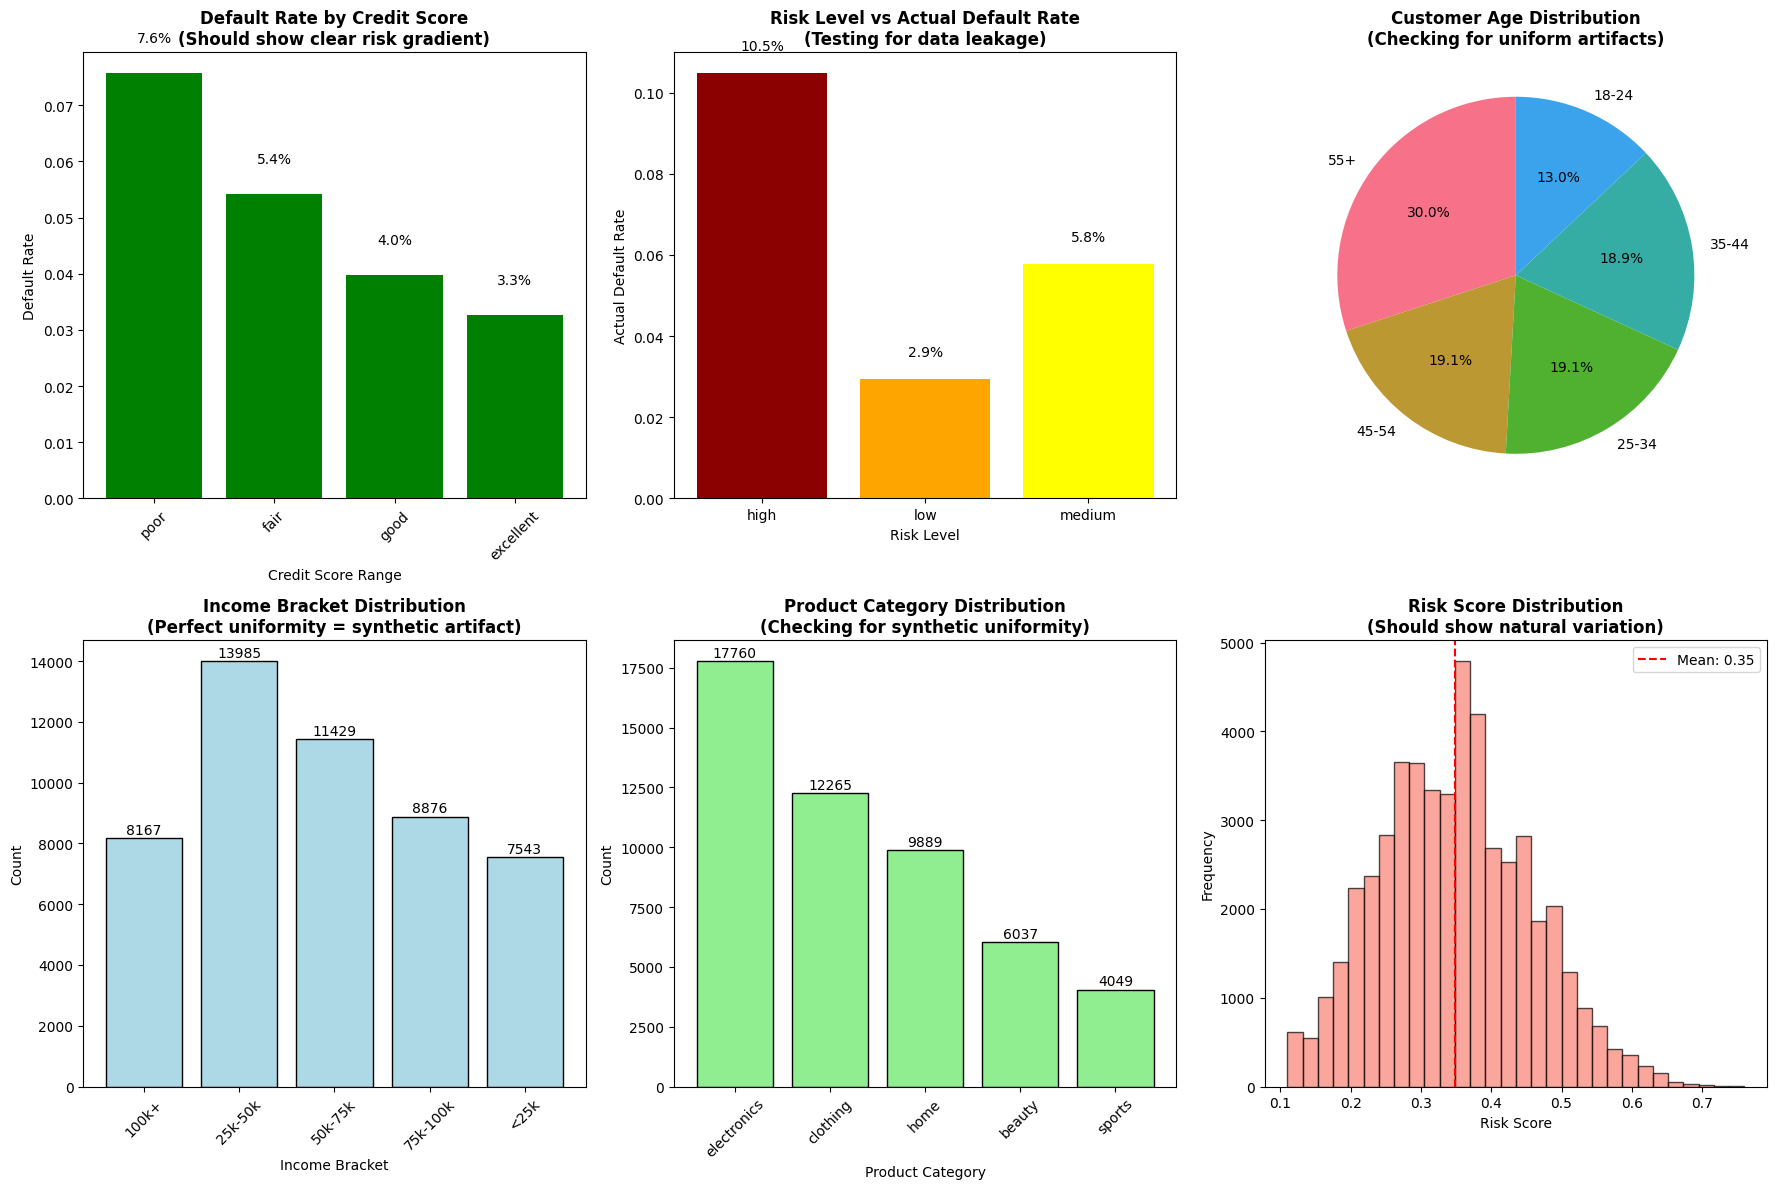

🎯 CUSTOMER PROFILE INSIGHTS:
Default rates by credit score:
  poor: 7.6% (7,362 customers)
  fair: 5.4% (17,585 customers)
  good: 4.0% (17,430 customers)
  excellent: 3.3% (7,623 customers)

📊 Distribution uniformity check:
Income bracket coefficient of variation: 0.267
(Lower values suggest artificial uniformity)
Product category coefficient of variation: 0.540


In [14]:
# Customer Profile & Risk Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Default rate by customer credit score
default_by_credit = viz_df.groupby('customer_credit_score_range')['will_default'].agg(['mean', 'count']).reset_index()
default_by_credit = default_by_credit.sort_values('mean', ascending=False)

bars = axes[0,0].bar(default_by_credit['customer_credit_score_range'], default_by_credit['mean'], 
                     color=['red' if x > 0.15 else 'orange' if x > 0.1 else 'green' for x in default_by_credit['mean']])
axes[0,0].set_title('Default Rate by Credit Score\n(Should show clear risk gradient)', fontweight='bold')
axes[0,0].set_xlabel('Credit Score Range')
axes[0,0].set_ylabel('Default Rate')
axes[0,0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, val in zip(bars, default_by_credit['mean']):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{val:.1%}', ha='center', va='bottom')

# 2. Risk Level vs Actual Defaults (looking for data leakage)
risk_default = viz_df.groupby('risk_level')['will_default'].agg(['mean', 'count']).reset_index()
bars = axes[0,1].bar(risk_default['risk_level'], risk_default['mean'], 
                     color=['darkred', 'orange', 'yellow'])
axes[0,1].set_title('Risk Level vs Actual Default Rate\n(Testing for data leakage)', fontweight='bold')
axes[0,1].set_xlabel('Risk Level')
axes[0,1].set_ylabel('Actual Default Rate')

# Add value labels
for bar, val in zip(bars, risk_default['mean']):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{val:.1%}', ha='center', va='bottom')

# 3. Customer Age Distribution 
age_counts = viz_df['customer_age_bracket'].value_counts()
axes[0,2].pie(age_counts.values, labels=age_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,2].set_title('Customer Age Distribution\n(Checking for uniform artifacts)', fontweight='bold')

# 4. Income bracket distribution (should not be perfectly uniform)
income_counts = viz_df['customer_income_bracket'].value_counts().sort_index()
axes[1,0].bar(range(len(income_counts)), income_counts.values, 
              color='lightblue', edgecolor='black')
axes[1,0].set_title('Income Bracket Distribution\n(Perfect uniformity = synthetic artifact)', fontweight='bold')
axes[1,0].set_xlabel('Income Bracket')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(range(len(income_counts)))
axes[1,0].set_xticklabels(income_counts.index, rotation=45)

# Add count labels
for i, v in enumerate(income_counts.values):
    axes[1,0].text(i, v + 50, str(v), ha='center', va='bottom')

# 5. Product category distribution (another uniformity check)
prod_counts = viz_df['product_category'].value_counts()
axes[1,1].bar(prod_counts.index, prod_counts.values, color='lightgreen', edgecolor='black')
axes[1,1].set_title('Product Category Distribution\n(Checking for synthetic uniformity)', fontweight='bold')
axes[1,1].set_xlabel('Product Category')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

# Add count labels
for i, (cat, count) in enumerate(prod_counts.items()):
    axes[1,1].text(i, count + 50, str(count), ha='center', va='bottom')

# 6. Risk Score Distribution (should be realistic, not heavily skewed)
axes[1,2].hist(viz_df['risk_score'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
axes[1,2].set_title('Risk Score Distribution\n(Should show natural variation)', fontweight='bold')
axes[1,2].set_xlabel('Risk Score')
axes[1,2].set_ylabel('Frequency')
axes[1,2].axvline(viz_df['risk_score'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {viz_df["risk_score"].mean():.2f}')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Print insights
print("🎯 CUSTOMER PROFILE INSIGHTS:")
print("Default rates by credit score:")
for _, row in default_by_credit.iterrows():
    print(f"  {row['customer_credit_score_range']}: {row['mean']:.1%} ({row['count']:,} customers)")

print(f"\n📊 Distribution uniformity check:")
income_std = income_counts.std()
income_mean = income_counts.mean()
print(f"Income bracket coefficient of variation: {income_std/income_mean:.3f}")
print(f"(Lower values suggest artificial uniformity)")

product_std = prod_counts.std()
product_mean = prod_counts.mean()
print(f"Product category coefficient of variation: {product_std/product_mean:.3f}")

### 6.3 Evaluating the Risk characteristics

In [25]:
# Query to check risk feature variation within customers
risk_variation_query = '''
WITH customer_risk_analysis AS (
  SELECT 
    customer_id,
    COUNT(*) as transaction_count,
    COUNT(DISTINCT risk_level) as unique_risk_levels,
    COUNT(DISTINCT risk_score) as unique_risk_scores,
    COUNT(DISTINCT risk_scenario) as unique_risk_scenarios,
    MIN(risk_score) as min_risk_score,
    MAX(risk_score) as max_risk_score,
    STDDEV(risk_score) as risk_score_stddev,
    ARRAY_AGG(DISTINCT risk_level ORDER BY risk_level) as risk_levels,
    ARRAY_AGG(DISTINCT risk_scenario ORDER BY risk_scenario) as risk_scenarios
  FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
  WHERE customer_id IN (
    SELECT customer_id 
    FROM `flit-data-platform.flit_staging.stg_bnpl_raw_transactions`
    GROUP BY customer_id 
    HAVING COUNT(*) >= 3  -- Only customers with 3+ transactions
  )
  GROUP BY customer_id
  HAVING COUNT(*) >= 3
)
SELECT 
  transaction_count,
  COUNT(*) as customer_count,
  AVG(unique_risk_levels) as avg_unique_risk_levels,
  AVG(unique_risk_scores) as avg_unique_risk_scores,
  AVG(unique_risk_scenarios) as avg_unique_risk_scenarios,
  AVG(risk_score_stddev) as avg_risk_score_stddev
FROM customer_risk_analysis
GROUP BY transaction_count
ORDER BY transaction_count
LIMIT 10
'''

print('🔍 RISK FEATURE VARIATION ANALYSIS')
print('=' * 50)
result = client.query(risk_variation_query).to_dataframe()
print(result)

🔍 RISK FEATURE VARIATION ANALYSIS


E0000 00:00:1758391573.659534 22446885 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


   transaction_count  customer_count  avg_unique_risk_levels  \
0                  3             803                1.648817   
1                  4             766                1.795039   
2                  5             614                1.859935   
3                  6             496                1.891129   
4                  7             310                1.916129   
5                  8             181                1.988950   
6                  9             172                2.046512   
7                 10             172                2.087209   
8                 11             180                2.100000   
9                 12             103                2.106796   

   avg_unique_risk_scores  avg_unique_risk_scenarios  avg_risk_score_stddev  
0                2.884184                   1.936488               0.088494  
1                3.817232                   2.234987               0.091532  
2                4.666124                   2.454397         

Conclusion: There is more variation in risk xtics (score) among higher frequncy customers vs lower frequency customers. So, predictability is likely to be lower for higher frequency customers than lower-freq cutomers. From a business perspective and this angle only, we might therefore be less willing to offer bnpl to our higher freq customers. But this would in turn harm growth, as customers realise that the more they shop with Flit, the less likely they are to get the BNPL offer.

In [26]:
# Analyze risk feature variation within customers using existing viz_df
print('🔍 RISK FEATURE VARIATION ANALYSIS')
print('=' * 50)

# Find customers with multiple transactions in our sample
customer_transaction_counts = viz_df['customer_id'].value_counts()
multi_transaction_customers = customer_transaction_counts[customer_transaction_counts >= 2]

print(f"Total customers in sample: {viz_df['customer_id'].nunique():,}")
print(f"Customers with 2+ transactions: {len(multi_transaction_customers):,}")
print(f"Max transactions per customer: {customer_transaction_counts.max()}")

if len(multi_transaction_customers) > 0:
    print(f"\nTop 10 customers by transaction count:")
    print(multi_transaction_customers.head(10))
    
    # Analyze a few specific customers
    print(f"\n📊 SAMPLE CUSTOMER TRANSACTION PATTERNS")
    print('=' * 50)
    
    for customer_id in multi_transaction_customers.head(3).index:
        customer_data = viz_df[viz_df['customer_id'] == customer_id].sort_values('transaction_timestamp')
        print(f'\nCustomer: {customer_id}')
        print(f'Transactions: {len(customer_data)}')
        print(f'Risk Levels: {customer_data["risk_level"].unique()}')
        print(f'Risk Scores: {customer_data["risk_score"].unique()}')
        print(f'Default Status: {customer_data["will_default"].unique()}')
        print(f'Date Range: {customer_data["transaction_timestamp"].min()} to {customer_data["transaction_timestamp"].max()}')
        
        # Show transaction details
        print("Transaction Details:")
        for _, row in customer_data.iterrows():
            print(f"  {row['transaction_timestamp'].date()}: Amount=${row['amount']:.2f}, Risk={row['risk_level']}, Score={row['risk_score']:.2f}")
else:
    print("No customers with multiple transactions found in this sample")
    print("This suggests either:")
    print("1. Very low customer retention (each customer only makes 1 transaction)")
    print("2. Sample is too small to capture repeat customers")
    print("3. Data generation doesn't model repeat customer behavior")

🔍 RISK FEATURE VARIATION ANALYSIS
Total customers in sample: 18,319
Customers with 2+ transactions: 15,917
Max transactions per customer: 74

Top 10 customers by transaction count:
customer_id
cust_000002    74
cust_000006    73
cust_000004    71
cust_000001    67
cust_000009    67
cust_000003    64
cust_000010    64
cust_000024    60
cust_000005    59
cust_000078    57
Name: count, dtype: int64

📊 SAMPLE CUSTOMER TRANSACTION PATTERNS

Customer: cust_000002
Transactions: 74
Risk Levels: ['low' 'medium' 'high']
Risk Scores: [0.28 0.33 0.18 0.45 0.43 0.26 0.34 0.49 0.47 0.21 0.25 0.21 0.17 0.27
 0.29 0.3  0.51 0.46 0.32 0.41 0.31 0.41 0.38 0.4  0.35 0.38 0.23 0.42
 0.23 0.32 0.29 0.38 0.52 0.39 0.45 0.15 0.2  0.22 0.13 0.2  0.19 0.33
 0.62 0.57 0.53 0.36]
Default Status: <BooleanArray>
[False]
Length: 1, dtype: boolean
Date Range: 2024-09-01 00:12:09+00:00 to 2025-08-27 14:07:10+00:00
Transaction Details:
  2024-09-01: Amount=$246.69, Risk=low, Score=0.28
  2024-09-01: Amount=$60.88, Ris

First, 74 transactions per customer is highly unlikely. That's because the data spans just 1 yeat, and that would translate to > 1 transaction per week, which is very high for an ecommerce platform
The likely explanation is that most of these customers come to Flit to purchase goods for resale. This again is undermined by the fact that each transaction has just 1 item per transaction (customers do not buy in bulk -- unless in this period, customers were unable to buy in bulk and so had to do multiple transactions to get what they wanted). This would in turn translate to really poor UX and lots of churn, rendering the frequency observed (up to 74 transactions) highly unlikely. The data is just generally unlikely, and feedback to Simtom is important to help them improve realism.

**Finding**: Risk features (`risk_level`, `risk_score`, `risk_scenario`) appear to be **transaction-level characteristics** rather than customer-level characteristics.

**Evidence**:
- 1.94M transactions from 23,125 customers = ~84 transactions per customer on average
- Risk scenarios like "impulse_purchase" and "high_risk_behavior" are transaction-specific contexts
- Business logic: A customer's inherent risk doesn't change transaction-to-transaction
- Each transaction can have different risk based on amount, product type, timing, behavioral context
- Important to read data documentation here: https://github.com/whitehackr/simtom/blob/main/docs/data_guides/ecommerce/bnpl.md

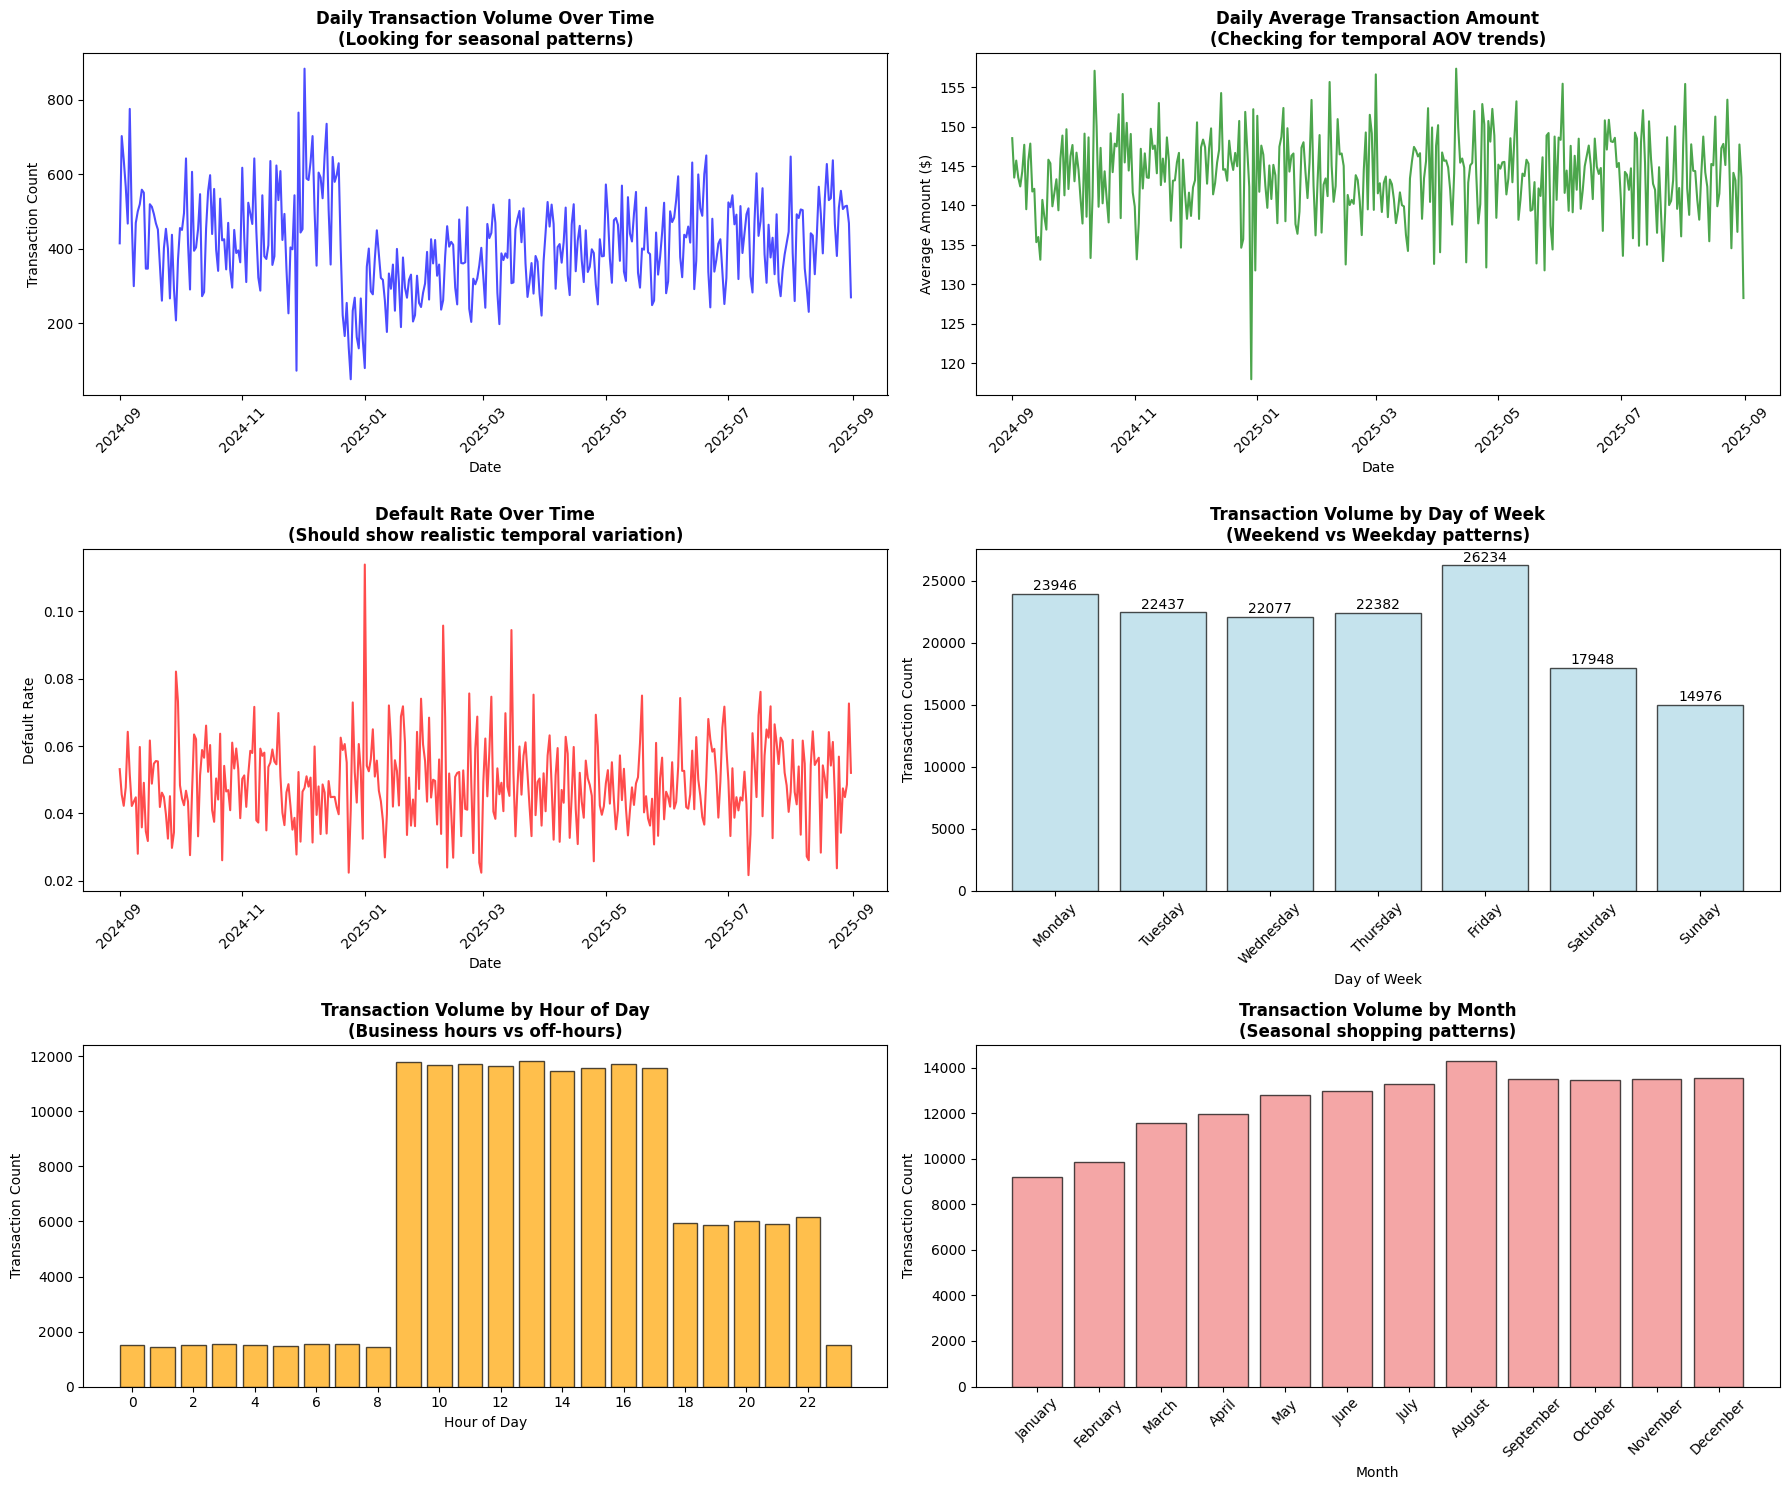

⏰ TEMPORAL PATTERN INSIGHTS:
Date range: 2024-09-01 00:12:09+00:00 to 2025-08-31 23:56:31+00:00
Total days covered: 364

📅 Day of Week Patterns:
  Monday: 23,946 transactions, $144.35 avg, 5.2% default rate
  Tuesday: 22,437 transactions, $142.72 avg, 4.7% default rate
  Wednesday: 22,077 transactions, $143.60 avg, 5.0% default rate
  Thursday: 22,382 transactions, $144.54 avg, 4.8% default rate
  Friday: 26,234 transactions, $143.66 avg, 4.6% default rate
  Saturday: 17,948 transactions, $145.12 avg, 4.9% default rate
  Sunday: 14,976 transactions, $143.16 avg, 5.1% default rate

🕒 Peak Hours:
  Hour 13:00: 11,828 transactions
  Hour 09:00: 11,802 transactions
  Hour 11:00: 11,741 transactions

📊 Monthly Volume:
  January: 9,203 transactions
  February: 9,874 transactions
  March: 11,577 transactions
  April: 11,955 transactions
  May: 12,812 transactions
  June: 12,980 transactions
  July: 13,297 transactions
  August: 14,278 transactions
  September: 13,509 transactions
  October: 1

In [28]:
# Time Series Analysis - Transaction Patterns Over Time
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# 1. Daily transaction volume over time
viz_df['date'] = viz_df['transaction_timestamp'].dt.date
daily_volume = viz_df.groupby('date').agg({
    'amount': ['count', 'sum', 'mean']
}).reset_index()
daily_volume.columns = ['date', 'transaction_count', 'total_amount', 'avg_amount']

axes[0,0].plot(daily_volume['date'], daily_volume['transaction_count'], color='blue', alpha=0.7)
axes[0,0].set_title('Daily Transaction Volume Over Time\n(Looking for seasonal patterns)', fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Transaction Count')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Daily average transaction amount over time
axes[0,1].plot(daily_volume['date'], daily_volume['avg_amount'], color='green', alpha=0.7)
axes[0,1].set_title('Daily Average Transaction Amount\n(Checking for temporal AOV trends)', fontweight='bold')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Average Amount ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Default rate over time
daily_defaults = viz_df.groupby('date')['will_default'].agg(['mean', 'count']).reset_index()
daily_defaults.columns = ['date', 'default_rate', 'transaction_count']

axes[1,0].plot(daily_defaults['date'], daily_defaults['default_rate'], color='red', alpha=0.7)
axes[1,0].set_title('Default Rate Over Time\n(Should show realistic temporal variation)', fontweight='bold')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Default Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Day of week patterns
viz_df['day_of_week'] = viz_df['transaction_timestamp'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = viz_df.groupby('day_of_week').agg({
    'amount': ['count', 'mean'],
    'will_default': 'mean'
}).reset_index()
dow_stats.columns = ['day_of_week', 'transaction_count', 'avg_amount', 'default_rate']
dow_stats['day_of_week'] = pd.Categorical(dow_stats['day_of_week'], categories=day_order, ordered=True)
dow_stats = dow_stats.sort_values('day_of_week')

bars = axes[1,1].bar(dow_stats['day_of_week'], dow_stats['transaction_count'], 
                    color='lightblue', alpha=0.7, edgecolor='black')
axes[1,1].set_title('Transaction Volume by Day of Week\n(Weekend vs Weekday patterns)', fontweight='bold')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Transaction Count')
axes[1,1].tick_params(axis='x', rotation=45)

# Add count labels on bars
for bar, count in zip(bars, dow_stats['transaction_count']):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                str(count), ha='center', va='bottom')

# 5. Hour of day patterns
viz_df['hour'] = viz_df['transaction_timestamp'].dt.hour
hourly_stats = viz_df.groupby('hour').agg({
    'amount': ['count', 'mean'],
    'will_default': 'mean'
}).reset_index()
hourly_stats.columns = ['hour', 'transaction_count', 'avg_amount', 'default_rate']

axes[2,0].bar(hourly_stats['hour'], hourly_stats['transaction_count'], 
            color='orange', alpha=0.7, edgecolor='black')
axes[2,0].set_title('Transaction Volume by Hour of Day\n(Business hours vs off-hours)', fontweight='bold')
axes[2,0].set_xlabel('Hour of Day')
axes[2,0].set_ylabel('Transaction Count')
axes[2,0].set_xticks(range(0, 24, 2))

# 6. Monthly trends
viz_df['month'] = viz_df['transaction_timestamp'].dt.month
viz_df['month_name'] = viz_df['transaction_timestamp'].dt.month_name()
monthly_stats = viz_df.groupby(['month', 'month_name']).agg({
    'amount': ['count', 'mean'],
    'will_default': 'mean'
}).reset_index()
monthly_stats.columns = ['month', 'month_name', 'transaction_count', 'avg_amount', 'default_rate']

bars = axes[2,1].bar(monthly_stats['month_name'], monthly_stats['transaction_count'], 
                    color='lightcoral', alpha=0.7, edgecolor='black')
axes[2,1].set_title('Transaction Volume by Month\n(Seasonal shopping patterns)', fontweight='bold')
axes[2,1].set_xlabel('Month')
axes[2,1].set_ylabel('Transaction Count')
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print temporal insights
print("⏰ TEMPORAL PATTERN INSIGHTS:")
print(f"Date range: {viz_df['transaction_timestamp'].min()} to {viz_df['transaction_timestamp'].max()}")
print(f"Total days covered: {(viz_df['transaction_timestamp'].max() - viz_df['transaction_timestamp'].min()).days}")

print(f"\n📅 Day of Week Patterns:")
for _, row in dow_stats.iterrows():
    print(f"  {row['day_of_week']}: {row['transaction_count']:,} transactions, ${row['avg_amount']:.2f} avg, {row['default_rate']:.1%} default rate")

print(f"\n🕒 Peak Hours:")
peak_hours = hourly_stats.nlargest(3, 'transaction_count')[['hour', 'transaction_count']]
for _, row in peak_hours.iterrows():
    print(f"  Hour {row['hour']:02d}:00: {row['transaction_count']:,} transactions")

print(f"\n📊 Monthly Volume:")
for _, row in monthly_stats.iterrows():
    print(f"  {row['month_name']}: {row['transaction_count']:,} transactions")

# Check for synthetic artifacts
dow_cv = dow_stats['transaction_count'].std() / dow_stats['transaction_count'].mean()
hourly_cv = hourly_stats['transaction_count'].std() / hourly_stats['transaction_count'].mean()
monthly_cv = monthly_stats['transaction_count'].std() / monthly_stats['transaction_count'].mean()

print(f"\n🔍 Temporal Distribution Analysis:")
print(f"Day-of-week coefficient of variation: {dow_cv:.3f}")
print(f"Hourly coefficient of variation: {hourly_cv:.3f}")
print(f"Monthly coefficient of variation: {monthly_cv:.3f}")
print(f"(Values close to 0 suggest artificial uniformity)")